In [2]:
!pip install torch torchvision faiss-cpu faiss-gpu pillow

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [3]:
import os
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

def load_image(image_path, *, transform=None):
    image = Image.open(image_path).convert("RGB")  # Đảm bảo hình ảnh ở định dạng RGB
    if transform is not None:
        image = transform(image)
    return image

class ImageListDataset(Dataset):
    def __init__(self, image_dir):
        self.image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        self.transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        return load_image(self.image_paths[idx], transform=self.transform)


In [11]:
import faiss
import numpy as np
import torch
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader

class DinoV2Extractor:
    def __init__(self, model_name='dinov2_vits14', batch_size=1, num_workers=4, index_file='faiss_index.idx', gpu=False):
        self.model_name = model_name
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.index_file = index_file
        self.device = 'cuda' if gpu and torch.cuda.is_available() else 'cpu'
        self.model = None
        self.transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ])

    def setup(self):
        if self.model is None:
            self.model = torch.hub.load('facebookresearch/dinov2', self.model_name).to(self.device)
            self.model.eval()

    def extract(self, image_dir):
        self.setup()
        dataset = ImageListDataset(image_dir, transform=self.transform)
        dataloader = DataLoader(
            dataset,
            shuffle=False,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            pin_memory=True
        )

        features = []
        with torch.no_grad():
            for x in dataloader:
                x = x.to(self.device, non_blocking=True)
                fv = self.model(x).cpu().numpy()
                features.append(fv)
        features = np.concatenate(features, axis=0)
        return features

    def create_faiss_index(self, features):
        feature_dim = features.shape[1]
        index = faiss.IndexFlatL2(feature_dim)
        index.add(features)
        faiss.write_index(index, self.index_file)
        print(f"FAISS index saved to {self.index_file}")

    def load_faiss_index(self):
        return faiss.read_index(self.index_file)


In [12]:
class ImageListDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = load_image(self.image_paths[idx], transform=self.transform)
        return image


In [16]:
def search_similar_images(query_image_path, extractor):
    # Tải hình ảnh và áp dụng biến đổi
    query_image = load_image(query_image_path, transform=extractor.transform).unsqueeze(0)

    # Trích xuất đặc trưng từ hình ảnh
    with torch.no_grad():  # Đảm bảo không tính toán gradient
        query_image = query_image.to(extractor.device)
        query_features = extractor.model(query_image).detach().cpu().numpy()  # Sử dụng detach để tách khỏi đồ thị gradient

    # Tìm kiếm trong chỉ mục FAISS
    index = extractor.load_faiss_index()
    distances, indices = index.search(query_features, k=5)

    return distances, indices



In [14]:
# Đường dẫn đến thư mục chứa hình ảnh
image_dir = "/content/drive/MyDrive/AIO-2024/pipeline-hcm-ai/images"

# Tạo đối tượng extractor và trích xuất đặc trưng từ hình ảnh trong thư mục
extractor = DinoV2Extractor(model_name='dinov2_vits14', batch_size=1, num_workers=4, index_file='faiss_index.idx', gpu=False)
features = extractor.extract(image_dir)
extractor.create_faiss_index(features)

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


FAISS index saved to faiss_index.idx


In [17]:
# Tìm kiếm hình ảnh tương tự
query_image_path = "/content/drive/MyDrive/AIO-2024/pipeline-hcm-ai/notebooks/data_extraction/transnet/Keyframes/L21/V001/000033.jpg"
distances, indices = search_similar_images(query_image_path, extractor)

# In ra kết quả tìm kiếm
print(f"Top {len(indices[0])} similar images:")
for i in range(len(indices[0])):
    print(f"Image index: {indices[0][i]}, Distance: {distances[0][i]}")

Top 5 similar images:
Image index: 116, Distance: 2001.576904296875
Image index: 65, Distance: 2028.6041259765625
Image index: 1, Distance: 2121.0615234375
Image index: 68, Distance: 2140.843994140625
Image index: 62, Distance: 2260.97119140625


In [18]:
import argparse
import logging
import os
import numpy as np
import torch
from PIL import Image
from torchvision import transforms
import faiss
import matplotlib.pyplot as plt


In [19]:
# Tạo class ImageListDataset
class ImageListDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths):
        self.image_paths = image_paths
        self.transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        return load_image(self.image_paths[idx], transform=self.transform)

In [20]:
# Hàm load_image
def load_image(image_path, *, transform=None):
    image = Image.open(image_path).convert("RGB")
    if transform is not None:
        image = transform(image)
    return image

In [21]:
# Hàm trích xuất đặc trưng hình ảnh
class DinoV2Extractor:
    def __init__(self, model_name='dinov2_vits14', batch_size=1, num_workers=4, index_file='faiss_index.idx', gpu=False):
        self.model_name = model_name
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.index_file = index_file
        self.device = 'cuda' if gpu and torch.cuda.is_available() else 'cpu'
        self.model = None
        self.transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ])
        self.setup()

    def setup(self):
        if self.model is None:
            self.model = torch.hub.load('facebookresearch/dinov2', self.model_name).to(self.device)
            self.model.eval()

    def extract(self, image_paths):
        self.setup()

        dataset = ImageListDataset(image_paths)
        dataloader = torch.utils.data.DataLoader(
            dataset,
            shuffle=False,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            pin_memory=True
        )

        features = []
        with torch.no_grad():
            for x in dataloader:
                x = x.to(self.device, non_blocking=True)
                fv = self.model(x).detach().cpu().numpy()
                features.append(fv)
        features = np.concatenate(features, axis=0)
        return features

    def create_faiss_index(self, features):
        feature_dim = features.shape[1]
        index = faiss.IndexFlatL2(feature_dim)
        index.add(features)
        faiss.write_index(index, self.index_file)

    def load_faiss_index(self):
        return faiss.read_index(self.index_file)

In [37]:
# Hàm tìm kiếm hình ảnh tương tự
def search_similar_images(query_image_path, extractor):
    query_image = load_image(query_image_path, transform=extractor.transform).unsqueeze(0)

    with torch.no_grad():
        query_image = query_image.to(extractor.device)
        query_features = extractor.model(query_image).detach().cpu().numpy()

    index = extractor.load_faiss_index()
    distances, indices = index.search(query_features, k=5)

    return distances, indices

In [54]:
def display_similar_images(image_dir, indices, distances, num_display=5):
    image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # Điều chỉnh số lượng hình ảnh hiển thị
    num_images = min(num_display, len(indices[0]))

    fig, axes = plt.subplots(1, num_images + 1, figsize=(15, 5))
    axes[0].imshow(load_image(query_image_path))
    axes[0].set_title("Query Image")
    axes[0].axis('off')

    for i in range(num_images):
        img_path = image_paths[indices[0][i]]
        image = Image.open(img_path)
        axes[i + 1].imshow(image)
        axes[i + 1].set_title(f"Image {indices[0][i]}\nDist: {distances[0][i]:.2f}")
        axes[i + 1].axis('off')

    plt.show()


In [59]:
# Cài đặt đường dẫn
image_dir = "/content/drive/MyDrive/AIO-2024/pipeline-hcm-ai/images"
query_image_path = "/content/drive/MyDrive/AIO-2024/pipeline-hcm-ai/images/begin_40.jpg"


In [50]:
# Khởi tạo extractor và trích xuất đặc trưng
extractor = DinoV2Extractor(model_name='dinov2_vits14', batch_size=1, num_workers=4, index_file='faiss_index.idx', gpu=False)
features = extractor.extract([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
extractor.create_faiss_index(features)

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


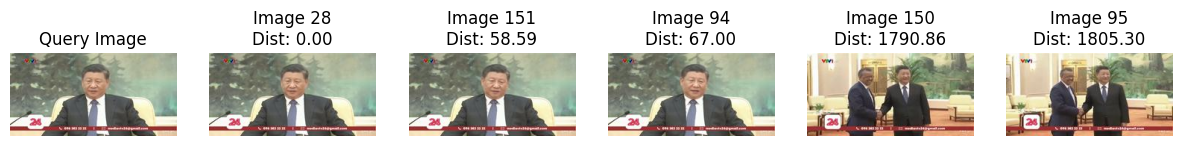

In [60]:
# Tìm kiếm và hiển thị hình ảnh tương tự
distances, indices = search_similar_images(query_image_path, extractor)
display_similar_images(image_dir, indices, distances, num_display=5)